In [8]:
import pandas as pd
import fpsnippets as fp
import numpy as np
import geopandas as gp
%matplotlib inline
import matplotlib.pyplot as plt

#Create the data fram from the .csv
asb = pd.read_csv("asbestos.csv", sep=",", low_memory=False)
fire = pd.read_csv("fire incidents.csv", sep=",", low_memory=False)
arrest = pd.read_csv("arrests.csv", sep=",", low_memory=False)
nbhInfo = pd.read_csv("neighborhoods.csv", sep=",", low_memory=False)

#Add a column for the neighborhoods to be placed
asb['neighborhood'] = ''
arrest['neighborhood'] = ''

#Setting up the dictionaries for the amount of occurances in the asbestos.csv and the square milage of each neighborhood
asbCount = dict()
arrestCount = dict()
fireCount = dict()
squareMiles = dict()

# gets neighborhoods in column of 'fire incidents'
neighborhoods_in_fire = fire['neighborhood'].unique()

# Filter rows in 'nbhInfo' where the hood is not in 'neighborhoods_in_fire'
nbhInfo_filtered = nbhInfo[nbhInfo['hood'].isin(neighborhoods_in_fire)]

# Here I am counting the fire incidents per neighborhood
fire_counts_per_neighborhood = fire['neighborhood'].value_counts().to_dict()

# updating the fire count dictionary
fireCount.update(fire_counts_per_neighborhood)

#Manually combined duplicate neighborhood under two names.
fireCount['Mt. Oliver'] += fireCount['Mount Oliver Borough']
del fireCount['Mount Oliver Borough']

#Iterate through Asbestos dataframe and add the neighborhood based on coors, then zip if no coors
for index, row in asb.iterrows():
    outGeo = fp.geo_to_neighborhood(row['latitude'], row['longitude'])
    outZip = fp.zip_to_neighborhoods(row['z_code'])
    final = ""
    if outGeo != "None":
        final = outGeo
    elif outZip!= "None":
        final = outZip
    else:
        final = "None"
    
    asb.at[index, "neighborhood"] = final
    
    #Manages a dictionary that I use later for my data frame
    if not(final in asbCount):
        asbCount[final] = int(1)
    else:
        asbCount[final] += int(1)

#Manually added cities from other datasets that were not in Asbestos
asbCount["Chartiers City"] = 0
asbCount["Arlington Heights"] = 0
asbCount["Glen Hazel"] = 0
        
#Iterate through the Arrests dataframe and add the neighborhood based on coors
for index, row in arrest.iterrows():
    outGeo = fp.geo_to_neighborhood(row['Y'], row['X'])
    final = ""
    if outGeo != "None":
        final = outGeo
    else:
        final = "None"
    
    arrest.at[index, "neighborhood"] = final
    
    #Manages a dictionary that I use later for my data frame
    if not(final in arrestCount):
        arrestCount[final] = int(1)
    else:
        arrestCount[final] += int(1)
        
#Removes data points with no location data
del asbCount[None]
del arrestCount[None]

#This pulls the square mile information for the various neighborhoods and puts them in a dictionary
for index, row in nbhInfo.iterrows():
        squareMiles[row['hood']] = row['sqmiles']

#This takes a while to compile, so I have this message for the sake of my sanity
print("Data imported!")

Data imported!


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b8d4477c0>,
      dtype=object)

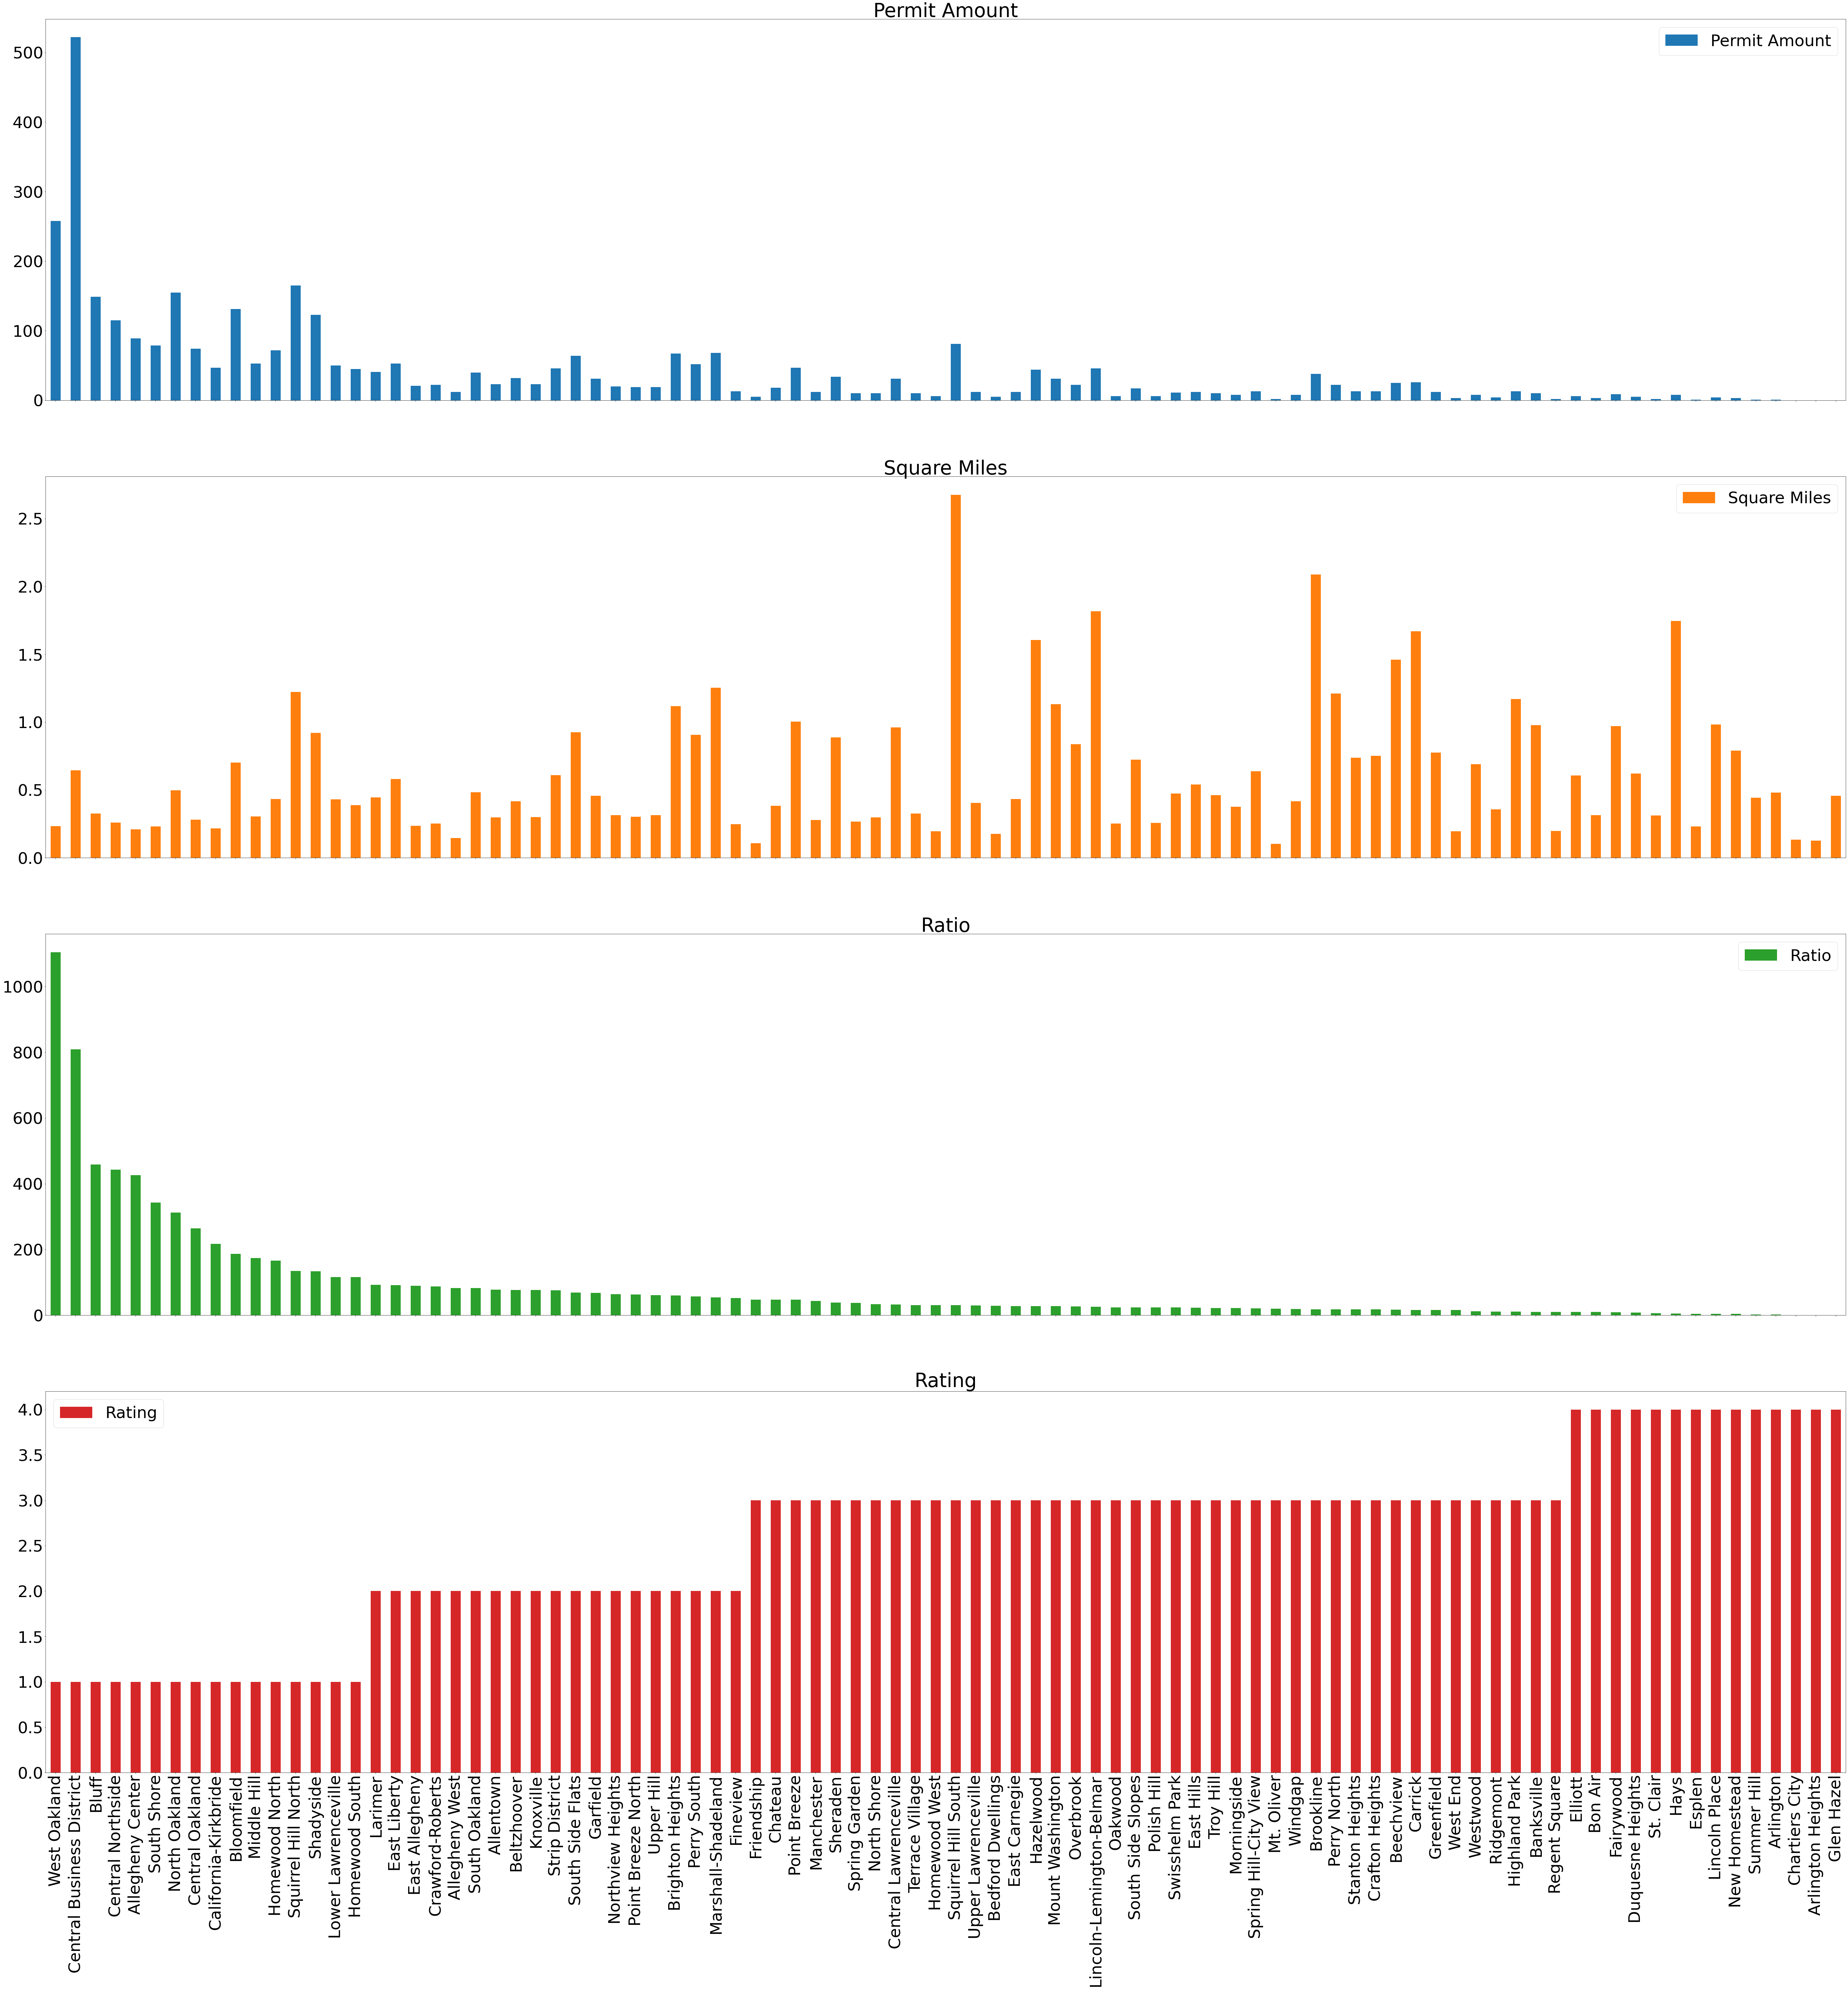

In [9]:
#This is for adjusting font size. Before I found this, the neighborhoods were unreadable
plt.rcParams.update({'font.size': 50})

#The final dataframe that I create from all the other previous dataframe and dictionaries
occurAsb = pd.Series(asbCount).sort_values(ascending=False).to_frame()

#Assigns the column name for the 1st set of data, then adds columns for the other data that will be added.
occurAsb.columns =['Permit Amount']
occurAsb['Square Miles'] = ''
occurAsb['Ratio'] = ''
occurAsb['Rating'] = ''

for index, row in occurAsb.iterrows():
    #I determine the ratio by (amount of permits / square miles)
    ratio = row['Permit Amount']/float(squareMiles[index])
    
    #I made a general tier system for the neighborhoods based off the calculated ratio
    if ratio>100:
        rate = 1
    elif (ratio>50):
        rate = 2
    elif (ratio>10):
        rate = 3
    else:
        rate = 4
    
    #This just fills in the rest of the data set as it iterates
    occurAsb.at[index,'Rating'] = rate
    occurAsb.at[index,'Square Miles'] = squareMiles[index]
    occurAsb.at[index,'Ratio'] = ratio

#I decided to use bar graphs for the time being, I may look into other types later. Figsize determines the dimensions, subplots makes a unique graph for each set of values in the frame.
occurAsb.sort_values(by=['Ratio'], ascending=False).plot.bar(figsize=(100,100), subplots=True)

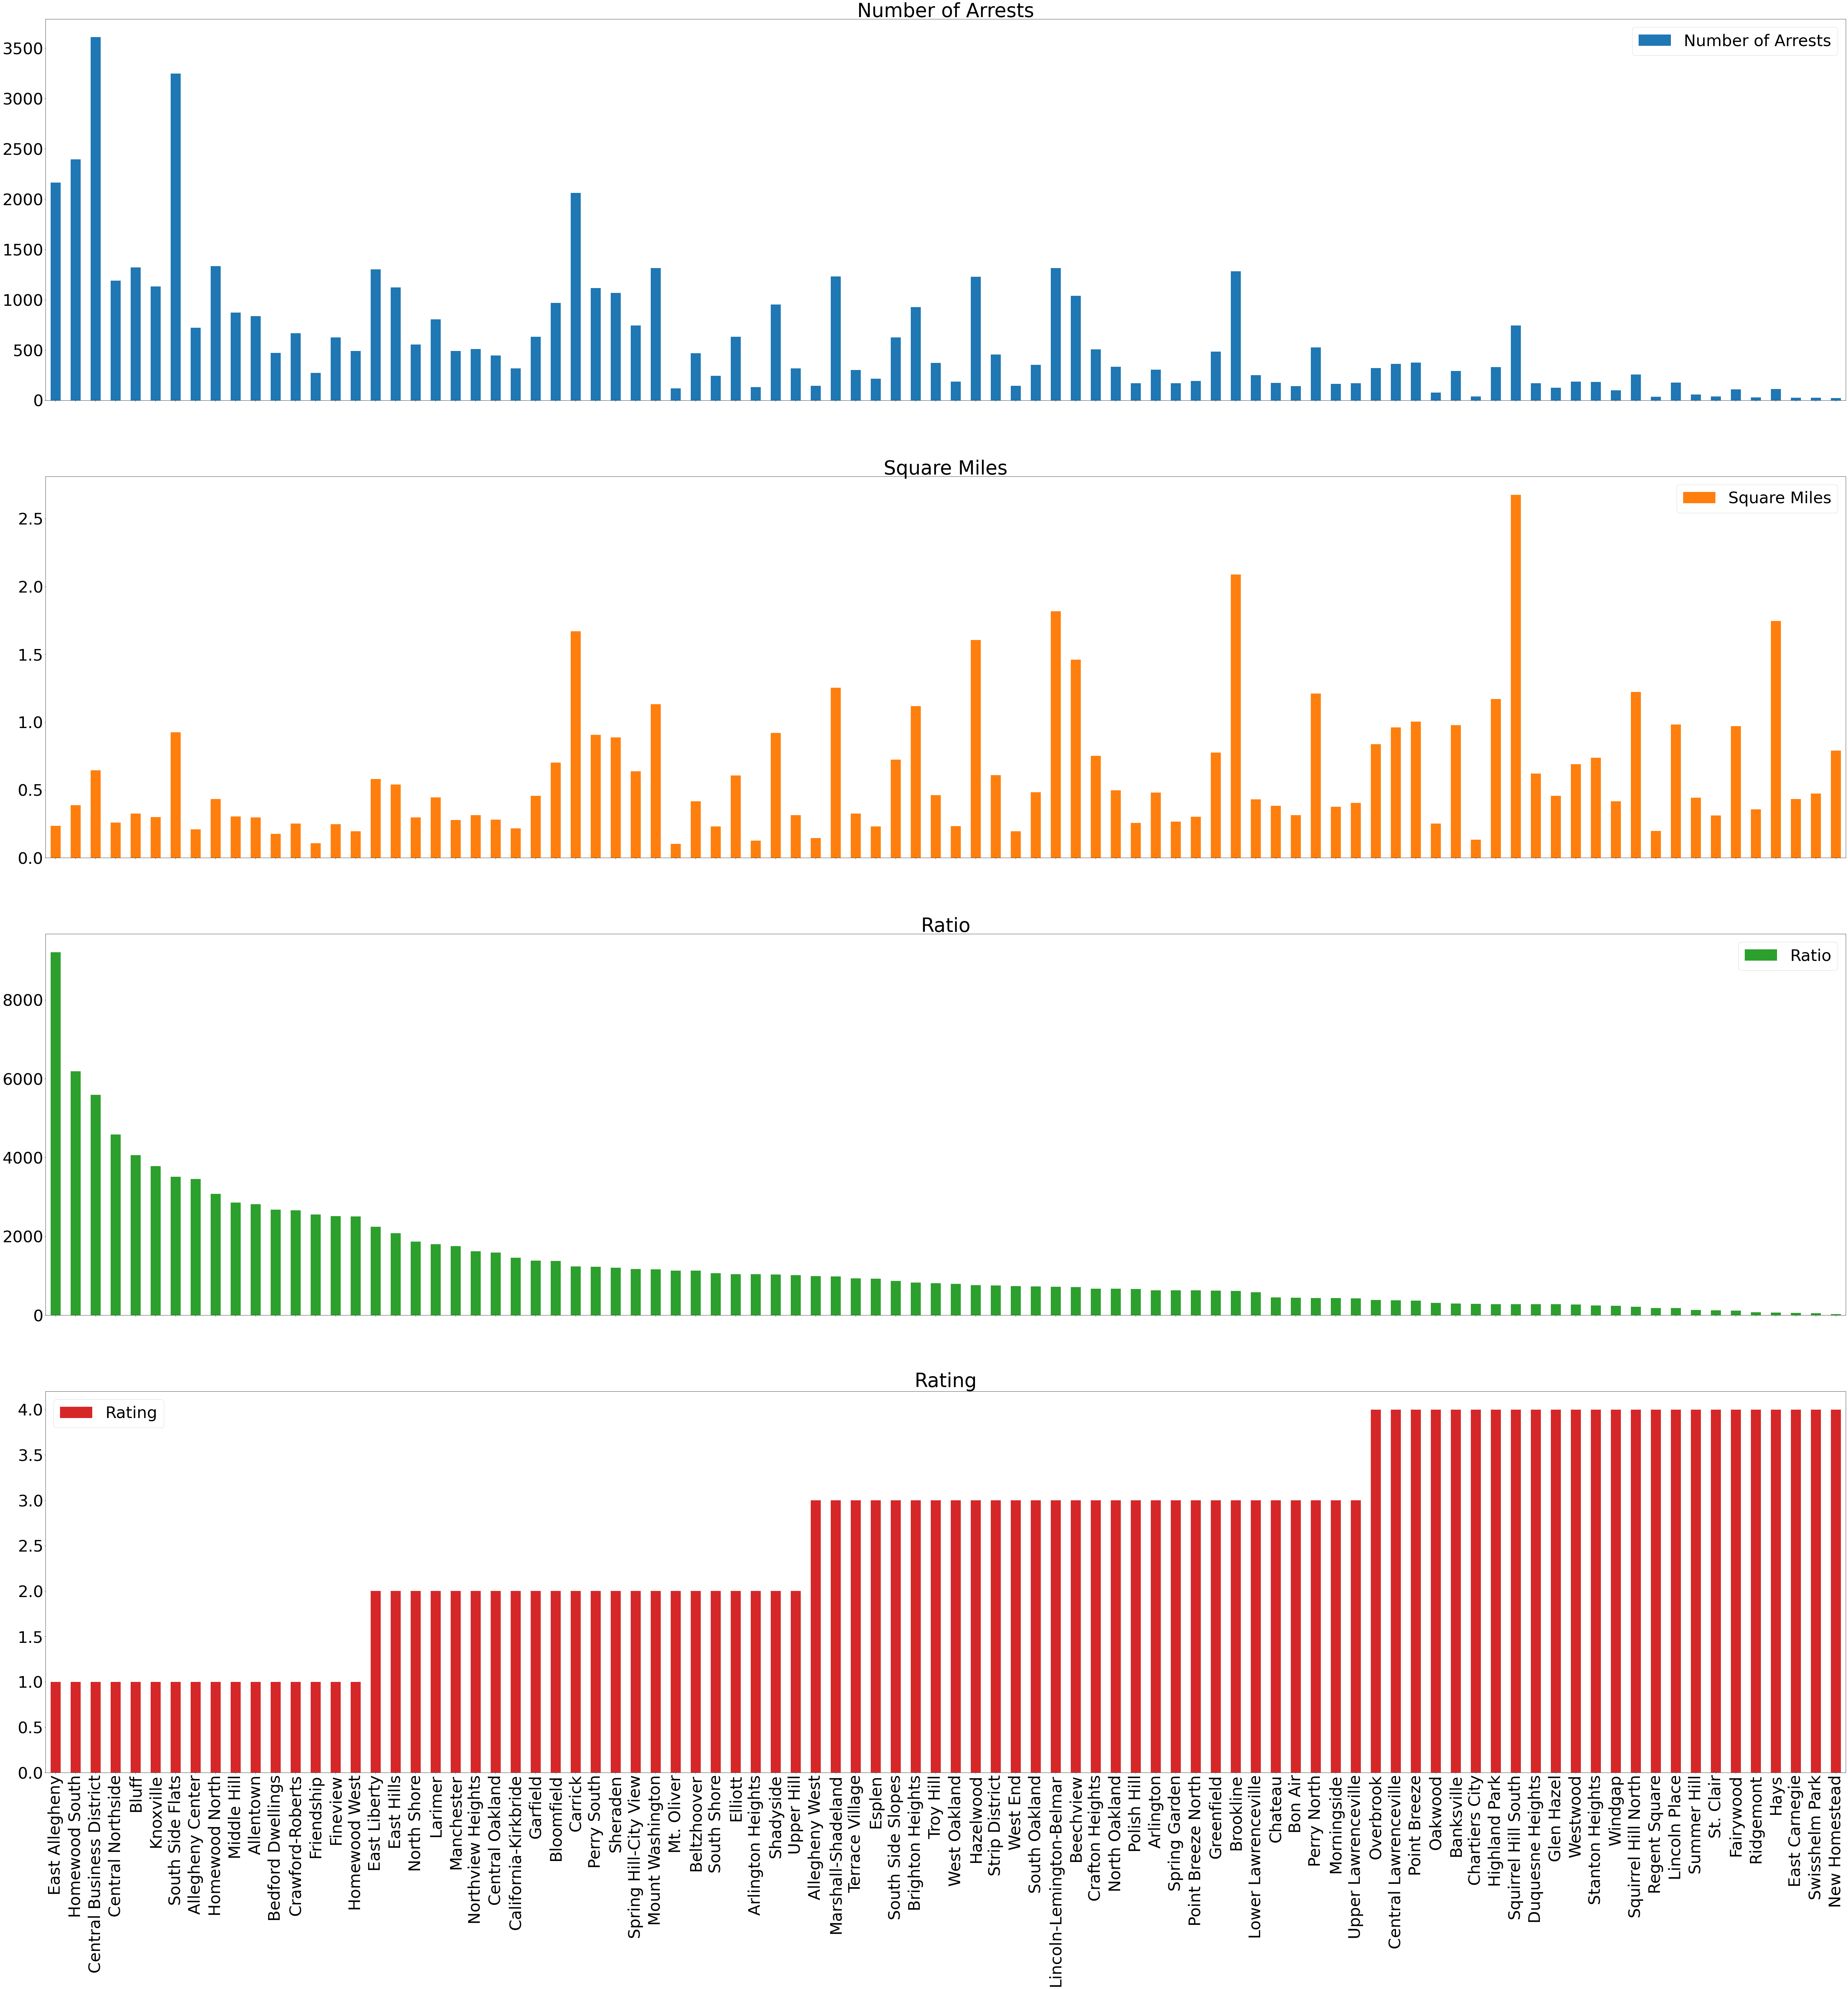

In [10]:
#This is for adjusting font size. Before I found this, the neighborhoods were unreadable
plt.rcParams.update({'font.size': 50})

#The final dataframe that I create from all the other previous dataframe and dictionaries
occurArr = pd.Series(arrestCount).sort_values(ascending=False).to_frame()

#Assigns the column name for the 1st set of data, then adds columns for the other data that will be added.
occurArr.columns =['Number of Arrests']
occurArr['Square Miles'] = ''
occurArr['Ratio'] = ''
occurArr['Rating'] = ''

#print(occur)

#Neigborhood names to title case for consistency
occurArr.index = occurArr.index.str.title()
squareMiles = {key.title(): value for key, value in squareMiles.items()}

for index, row in occurArr.iterrows():
    # Retrieve the square miles for the neighborhood (case-insensitive)
    square_miles = squareMiles.get(index, 0.0)
    
    # Determine the ratio by (amount of fire incidents / square miles)
    if square_miles != 0.0:
        ratio = row['Number of Arrests'] / float(square_miles)
    else:
        # Handle the case where square_miles is zero (set ratio to a default value)
        ratio = 0.0
    #same tier system as others
    if ratio>2250:
        rate = 1
    elif (ratio>1000):
        rate = 2
    elif (ratio>400):
        rate = 3
    else:
        rate = 4
    
    #This just fills in the rest of the data set as it iterates
    occurArr.at[index,'Rating'] = rate
    occurArr.at[index,'Square Miles'] = squareMiles.get(index,0.0)
    occurArr.at[index,'Ratio'] = ratio

#print(occur)
    
#I decided to use bar graphs for the time being, I may look into other types later. Figsize determines the dimensions, subplots makes a unique graph for each set of values in the frame.
occurArr.sort_values(by=['Ratio'], ascending=False).plot.bar(figsize=(100,100), subplots=True)
plt.show()

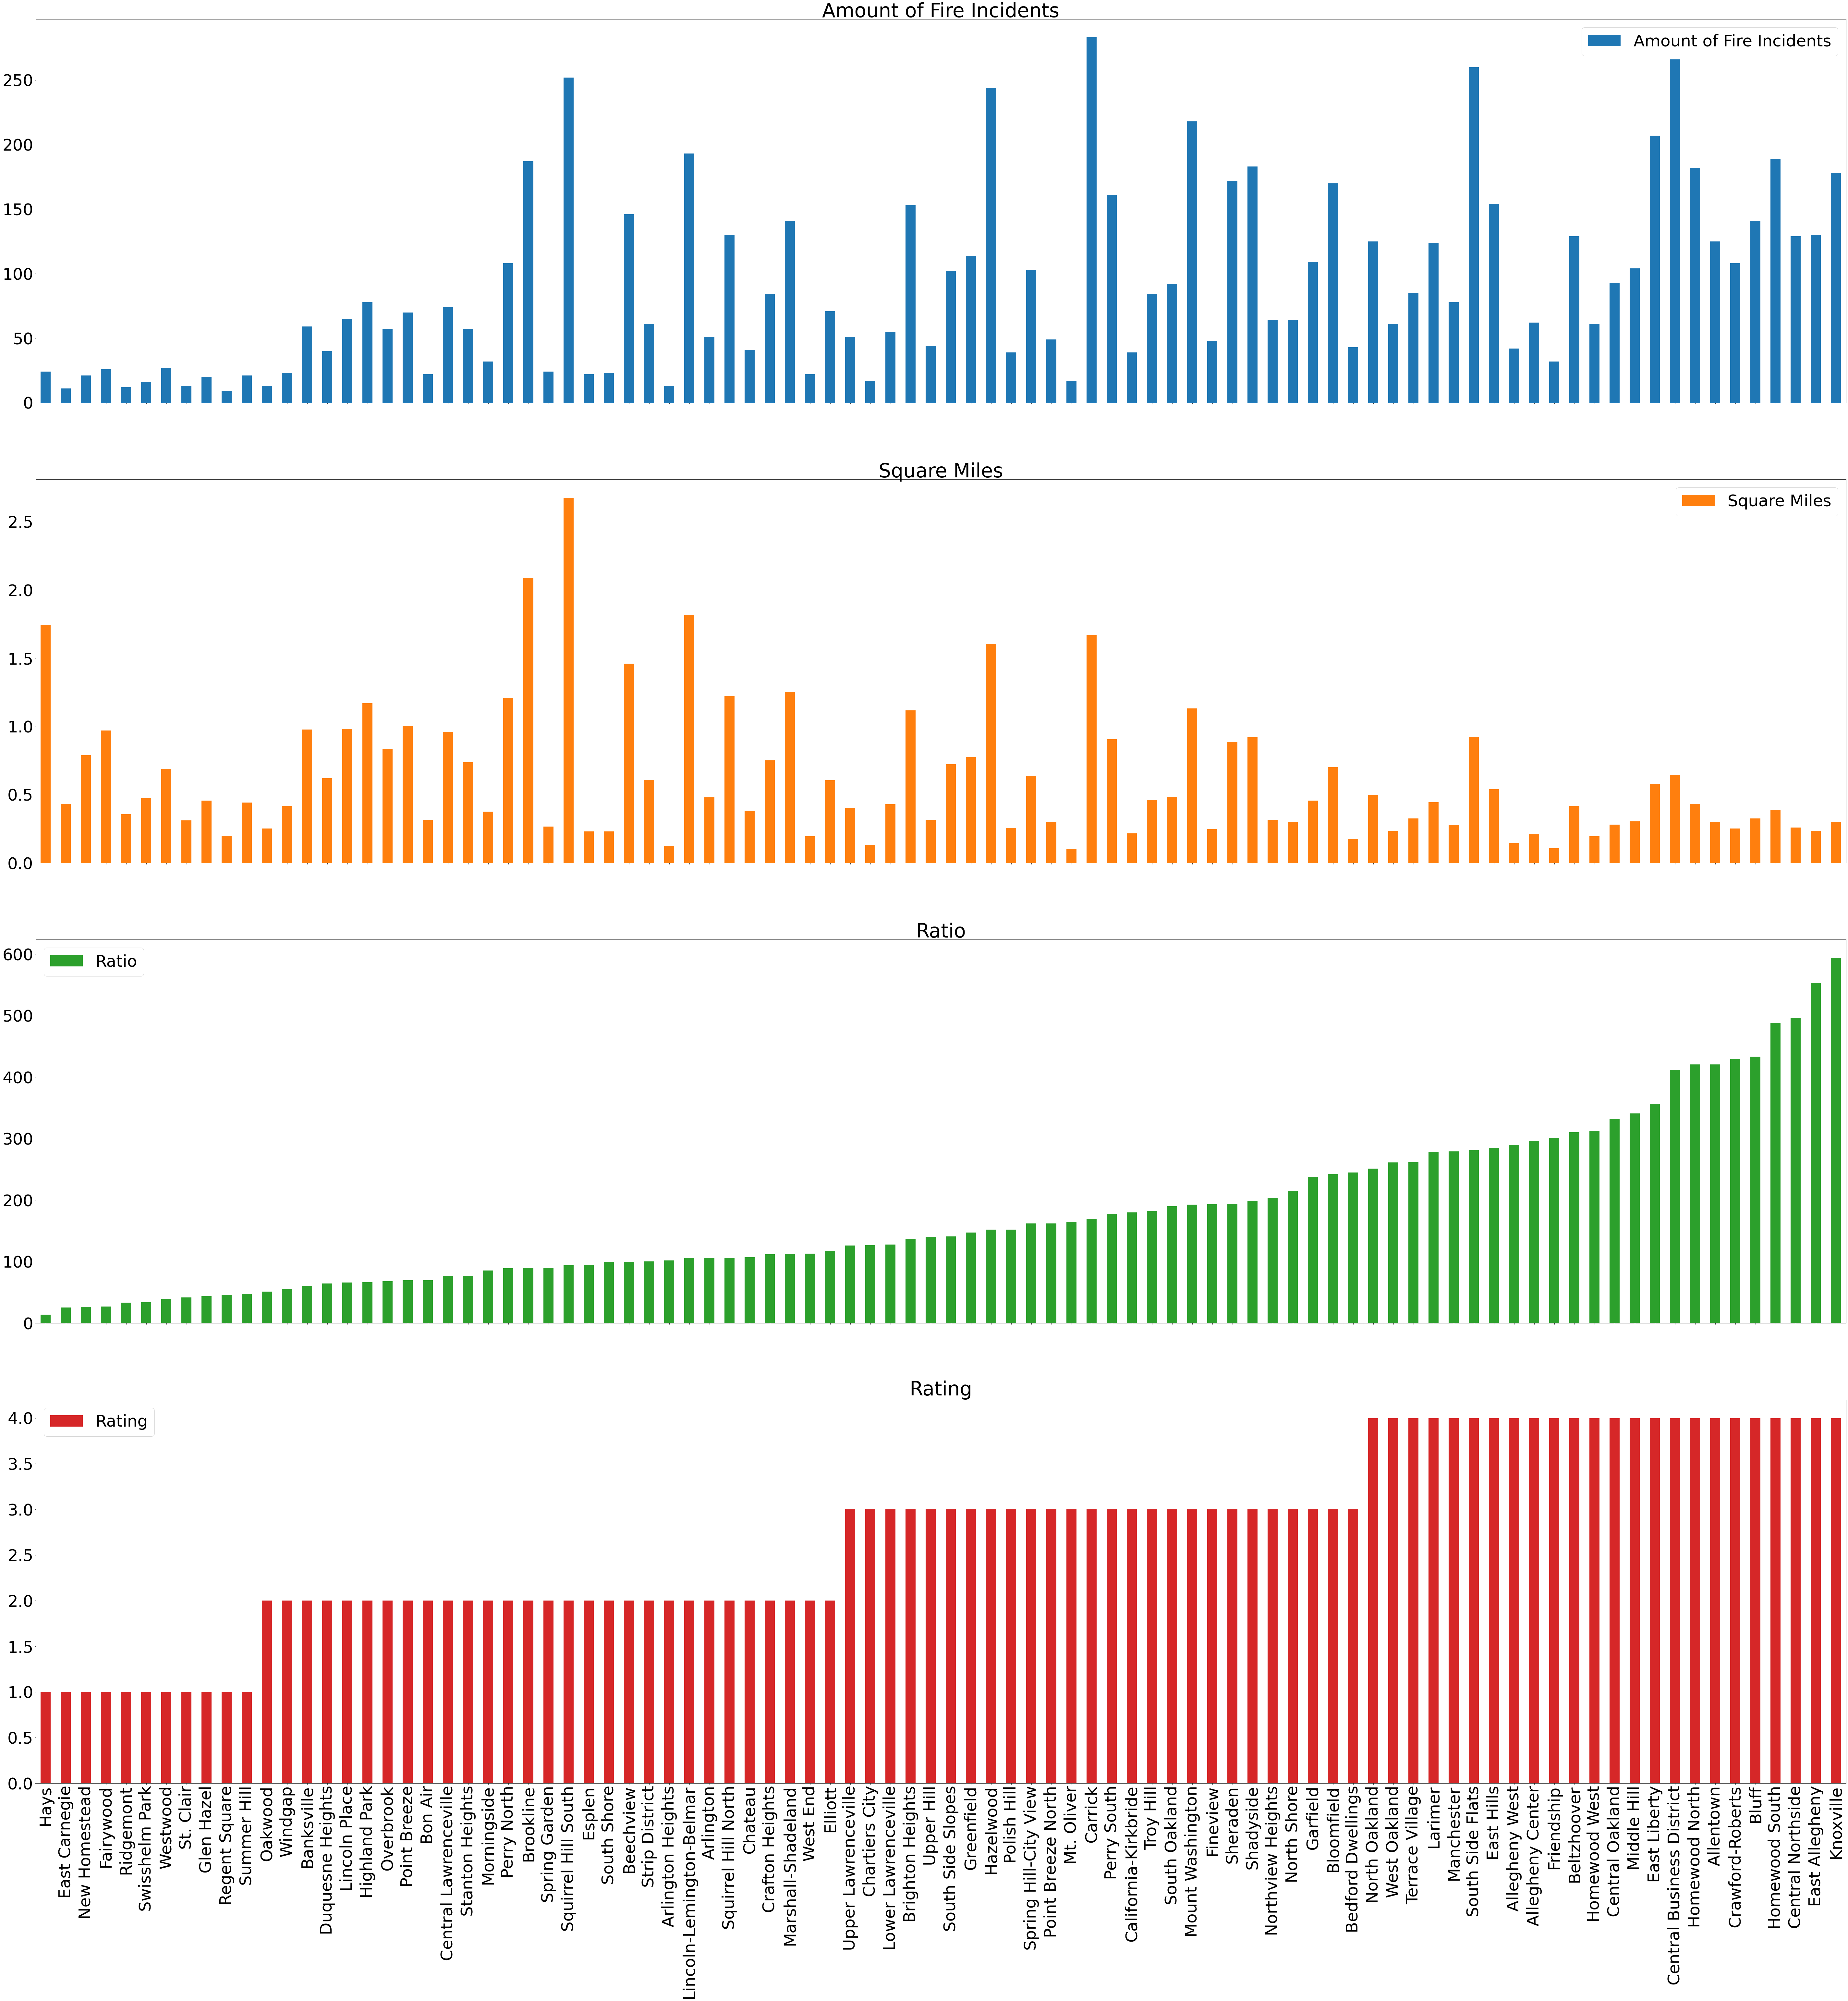

In [13]:
#Adjusting font size like my group member did
plt.rcParams.update({'font.size': 50})

#The final dataframe
incidents = pd.Series(fireCount).sort_values(ascending=False).to_frame()

#Columns for each data
incidents.columns =['Amount of Fire Incidents']
incidents['Square Miles'] = ''
incidents['Ratio'] = ''
incidents['Rating'] = ''

#Neigborhood names to title case for consistency
incidents.index = incidents.index.str.title()
squareMiles = {key.title(): value for key, value in squareMiles.items()}


for index, row in incidents.iterrows():
    # Retrieve the square miles for the neighborhood (case-insensitive)
    square_miles = squareMiles.get(index, 0.0)
    
    # Determine the ratio by (amount of fire incidents / square miles)
    if square_miles != 0.0:
        ratio = row['Amount of Fire Incidents'] / float(square_miles)
    else:
        # Handle the case where square_miles is zero (set ratio to a default value)
        ratio = 0.0
    #same tier system as others
    if ratio<50:
        rate = 1
    elif (ratio<125):
        rate = 2
    elif (ratio<250):
        rate = 3
    else:
        rate = 4
        
    
    #fills the rest of the dataset
    incidents.at[index,'Rating'] = rate
    incidents.at[index,'Square Miles'] = squareMiles.get(index,0.0)
    incidents.at[index,'Ratio'] = ratio

#same way data is displayed by groupmates.
incidents.sort_values(by=['Ratio'], ascending=True).plot.bar(figsize=(100,100), subplots=True)
plt.show()


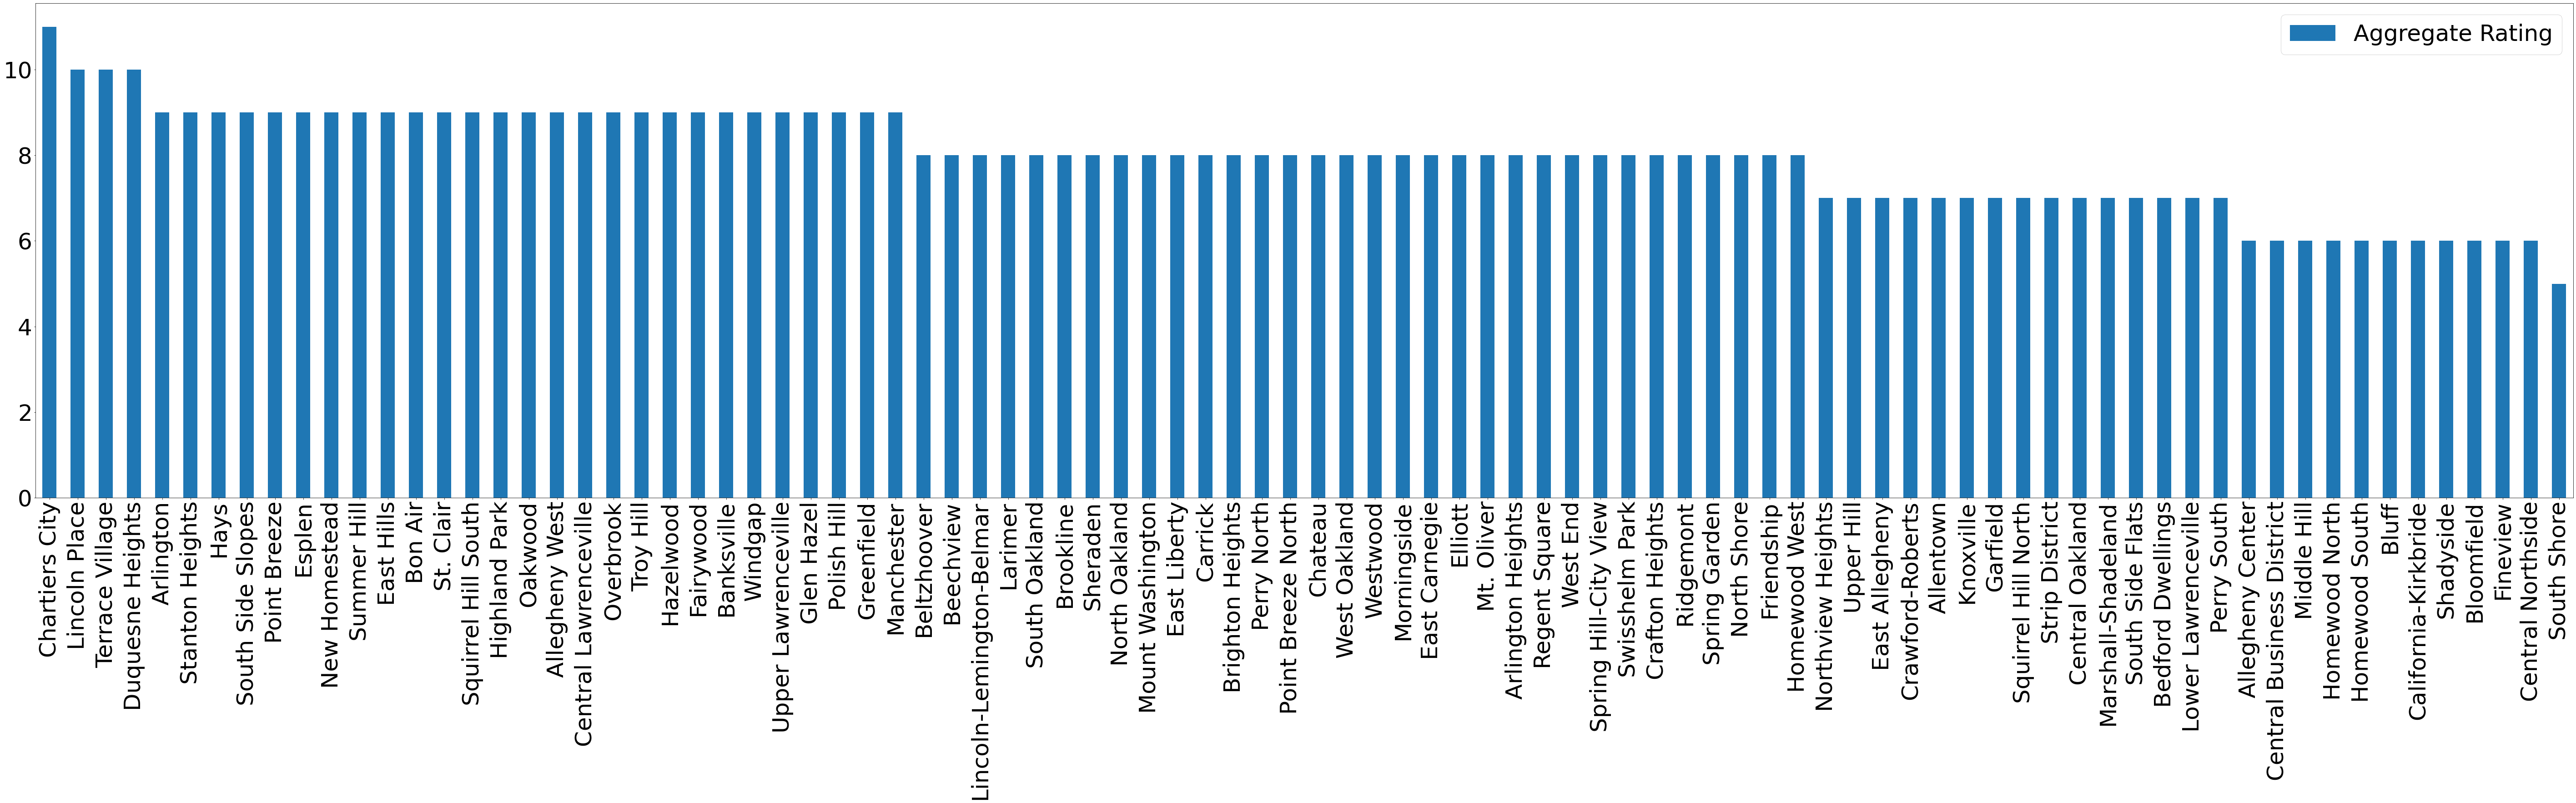

In [20]:
totalRating = dict()

for index, row in occurAsb.iterrows():
    totalRating[index] = occurAsb.at[index,'Rating'] + occurArr.at[index,'Rating'] + incidents.at[index,'Rating']
    
#print(totalRating)

ratingOutput = pd.Series(totalRating).sort_values(ascending=False).to_frame()
ratingOutput.columns = ['Aggregate Rating']
ratingOutput.sort_values(by=['Aggregate Rating'], ascending=False).plot.bar(figsize=(100,20))